In [1]:
import os
from glob import glob
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import mne
mne.set_log_level(verbose=False)
import wandb

from Datasets import *

In [2]:
config = {
    'epochs':10,
    'classes':5,
    'batch_size':32,
    'learning_rate':3e-4,
    'channels':['F4'],
    'patients_train':1,
    'patients_test':2,
    'binary':False,
    'metadata': "Test Normalización en memoria"
}

In [3]:
dataset1 = EDFData(path="../Data/PSG1.edf", channels=config["channels"], binary=False)
dataset2 = EDFData(path="../Data/PSG2.edf", channels=config["channels"], binary=False)

In [4]:
data1 = dataset1.epochs.get_data()
data2 = dataset2.epochs.get_data()
data1.shape, data2.shape

((882, 1, 15360), (840, 1, 15360))

In [5]:
data1 = np.squeeze(data1, axis=1)
data2 = np.squeeze(data2, axis=1)
data1.shape, data2.shape

((882, 15360), (840, 15360))

In [6]:
labels1 = dataset1.epochs.events[:,-1]
labels2 = dataset2.epochs.events[:,-1]
labels1.shape, labels2.shape

((882,), (840,))

In [7]:
print(dataset1.epochs.event_id)
print(dataset2.epochs.event_id)

{'Sleep stage N1': 1, 'Sleep stage N2': 2, 'Sleep stage N3': 3, 'Sleep stage R': 4, 'Sleep stage W': 5}
{'Sleep stage N1': 1, 'Sleep stage N2': 2, 'Sleep stage N3': 3, 'Sleep stage R': 4, 'Sleep stage W': 5}


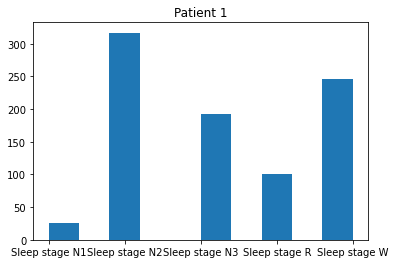

In [8]:
plt.hist(labels1)
plt.title("Patient 1")
plt.xticks(list(dataset1.epochs.event_id.values()), dataset1.epochs.event_id.keys())
plt.show()

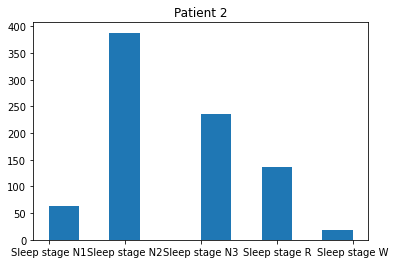

In [9]:
plt.hist(labels2)
plt.title("Patient 2")
plt.xticks(list(dataset2.epochs.event_id.values()), dataset2.epochs.event_id.keys())
plt.show()

## Obtain mean and std per channel (as of now we only have one channel so it should be easy)

In [10]:
mean1 = data1.mean()
std1 = data1.std()
mean1, std1

(2.941610868569235e-05, 0.0001535793839162135)

In [11]:
mean2 = data2.mean()
std2 = data2.std()
mean2, std2

(2.6143434005411677e-05, 0.00020400647906862842)

In [12]:
import scipy.stats as stats

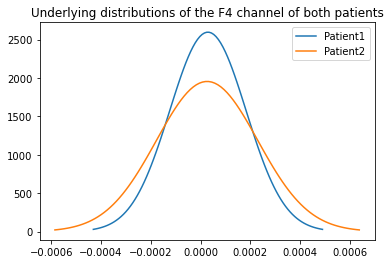

In [13]:
x = np.linspace(mean1 - 3*std1, mean1 + 3*std1, 100)
plt.plot(x, stats.norm.pdf(x, mean1, std1), label='Patient1')
x = np.linspace(mean2 - 3*std2, mean2 + 3*std2, 100)
plt.plot(x, stats.norm.pdf(x, mean2, std2), label='Patient2')
plt.legend()
plt.title("Underlying distributions of the F4 channel of both patients")
plt.show()

## Plot raw channel distribution and standarized

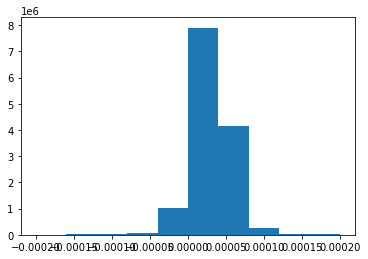

In [14]:
plt.hist(data1.flatten(), range=[-0.0002, 0.0002])
plt.show()

In [15]:
data1_std = (data1 - mean1)/std1

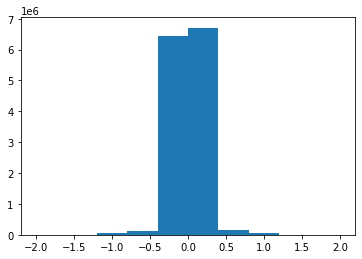

In [16]:
plt.hist(data1_std.flatten(), range=[-2,2])
plt.show()

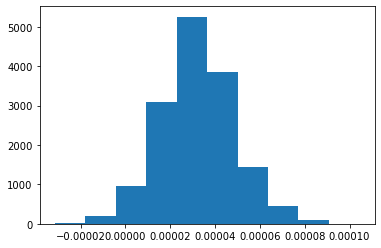

In [17]:
plt.hist(data1[0])
plt.show()

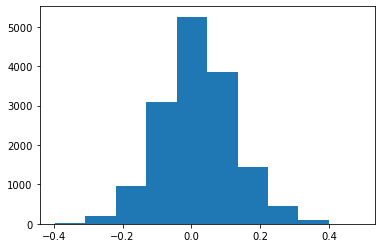

In [18]:
plt.hist(data1_std[0])
plt.show()

## First normalize each channel in itself and then std

In [19]:
np.abs(data1).max(axis=1)

array([1.04316777e-04, 7.10276951e-05, 6.97093156e-05, 6.47653925e-05,
       1.07283131e-04, 6.93797208e-05, 6.97093156e-05, 1.03987182e-04,
       8.58594644e-05, 1.02668803e-04, 4.09851225e-04, 9.27809567e-05,
       1.07283131e-04, 1.79134813e-04, 1.72872511e-04, 1.17500572e-04,
       1.08601511e-04, 1.73861295e-04, 1.29365988e-04, 1.21126116e-04,
       6.74845502e-04, 1.09260700e-04, 6.77317464e-05, 1.85397116e-04,
       9.31105516e-05, 8.84962234e-05, 7.92675669e-05, 9.08033875e-05,
       1.26729229e-04, 8.71778439e-05, 8.48706798e-05, 1.36287480e-04,
       9.57473106e-05, 9.27809567e-05, 1.08601511e-04, 1.04316777e-04,
       9.77248798e-05, 1.73531701e-04, 1.17500572e-04, 1.93636988e-04,
       1.14863813e-04, 1.22114900e-04, 1.26070039e-04, 1.28377203e-04,
       6.29691005e-04, 6.44357977e-05, 6.80613413e-05, 7.26756695e-05,
       7.82787823e-05, 7.66308080e-05, 1.70565347e-04, 1.50460060e-04,
       8.12451362e-05, 9.57473106e-05, 1.82430762e-04, 1.60677501e-04,
      

In [20]:
data1_norm = data1 / np.expand_dims(np.abs(data1).max(axis=1),-1)

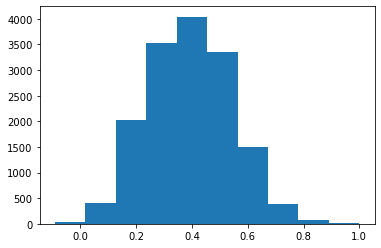

In [21]:
plt.hist(data1_norm[99])
plt.show()

In [22]:
data1_norm_std = (data1_norm - data1_norm.mean())/data1_norm.std()

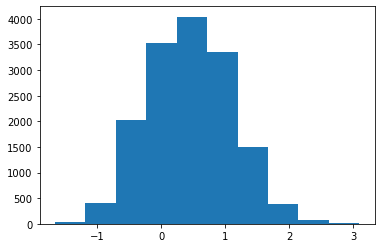

In [23]:
plt.hist(data1_norm_std[99])
plt.show()

In [24]:
data1_norm_nomean = (data1_norm - np.expand_dims(data1_norm.mean(axis=1),-1))

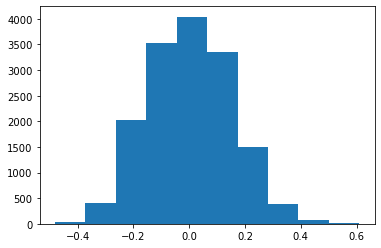

In [25]:
plt.hist(data1_norm_nomean[99])
plt.show()

## Testing with simple models

In [26]:
import tensorflow as tf

In [27]:
sampling_rate = 512

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=sampling_rate//2, strides=sampling_rate//4, activation="relu", input_shape=(15360,1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(config['classes'], activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# model.fit